In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import os
import time
import h5py
import pickle
import cv2
import tensorflow
import keras

from tqdm import tqdm
from sklearn import model_selection, preprocessing, metrics
from sklearn.utils import shuffle


import keras.backend.tensorflow_backend as KTF
from keras.models import Sequential, load_model
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

%matplotlib inline

Using TensorFlow backend.


In [2]:
ROOT_DIR = "./"
DATA_DIR = os.path.join(ROOT_DIR, "data/")

TRAIN_META = os.path.join(DATA_DIR, 'train.csv')
TEST_META = os.path.join(DATA_DIR, 'test.csv')
TRAIN_LABELS = os.path.join(DATA_DIR, 'train.txt')

TRAIN_FRAME_DIR = os.path.join(DATA_DIR, "train_frames/")
TEST_FRAME_DIR = os.path.join(DATA_DIR, "test_frames/")

METRICS_PATH = os.path.join(ROOT_DIR,'metrics/')
MODELS_PATH = os.path.join(ROOT_DIR,'models/')

In [3]:
y_train = pd.read_csv(TRAIN_LABELS, header=None, squeeze=True)
y_train.head()

0    28.105569
1    28.105569
2    28.106527
3    28.130404
4    28.109243
Name: 0, dtype: float64

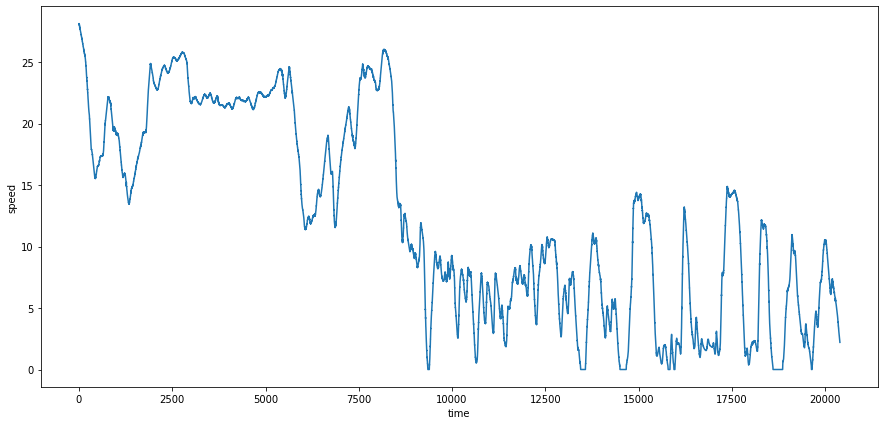

In [4]:
plt.figure(figsize=(15,7))
plt.ylabel('speed')
plt.xlabel('time')
plt.plot(y_train.index.values, y_train.values);

In [5]:
train_df = pd.read_csv(TRAIN_META)
test_df = pd.read_csv(TEST_META)

In [6]:
def batch_shuffle(df):
    """
    80%-20% pairwise train-test split
    """
    train_data = pd.DataFrame()
    valid_data = pd.DataFrame()
    for i in range(len(df) - 1):
        idx1 = np.random.randint(len(df) - 1)
        idx2 = idx1 + 1
        
        row1 = df.iloc[[idx1]].reset_index()
        row2 = df.iloc[[idx2]].reset_index()
        
        randInt = np.random.randint(9)
        if 0 <= randInt <= 1:
            valid_frames = [valid_data, row1, row2]
            valid_data = pd.concat(valid_frames, axis = 0, join = 'outer', ignore_index=False)
        if randInt >= 2:
            train_frames = [train_data, row1, row2]
            train_data = pd.concat(train_frames, axis = 0, join = 'outer', ignore_index=False)
    return train_data, valid_data

In [7]:
train_data, valid_data = batch_shuffle(train_df)

In [8]:
# print('Train:',str(50*len(train_data)/len(train_df)) + '%')
# print('Validation:',str(50*len(valid_data)/len(train_df)) + '%')

In [9]:
def change_brightness(image, bright_factor):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

In [10]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    hsv = np.zeros((66, 220, 3))
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current,
                                        gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)                                   

    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    
    # convert HSV to float32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb_flow

In [11]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (220, 66, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             3) resize to (220, 66, 3) if not done so already from perspective transform
    """
    image_cropped = image[25:375, :] # -> (350, 640, 3)
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    return image

In [12]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

def preprocess_image_from_path(image_path, speed, bright_factor):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = change_brightness(img, bright_factor)    
    img = preprocess_image(img)
    return img, speed

CV2 default img (BGR) (480, 640, 3)


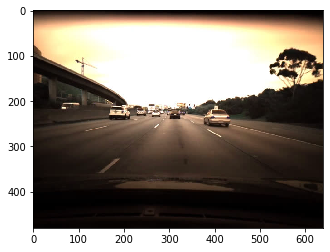

RGB img (480, 640, 3)


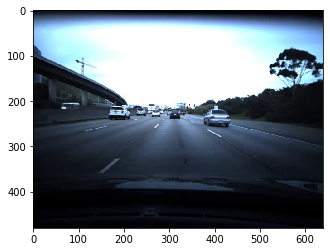

Change brightness img (480, 640, 3)


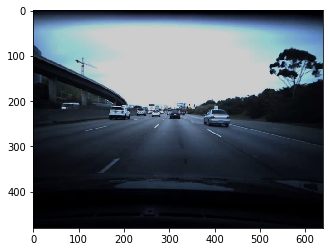

Resized img (66, 220, 3)


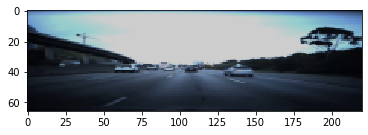

In [13]:
# Example image preprocessing
temp_bright_factor = 0.2 + np.random.uniform()
temp_img = cv2.imread(os.path.join(TRAIN_FRAME_DIR,'50.jpg'))
print('CV2 default img (BGR)', temp_img.shape)
plt.imshow(temp_img)
plt.show()
temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
print('RGB img', temp_img.shape)
plt.imshow(temp_img)
plt.show()
temp_img = change_brightness(temp_img, temp_bright_factor)
print('Change brightness img', temp_img.shape)
plt.imshow(temp_img)
plt.show()
temp_img = preprocess_image(temp_img)
print('Resized img', temp_img.shape)
plt.imshow(temp_img)
plt.show()

In [14]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) 
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            # generate a random index with a uniform random distribution from 1 to len - 1
            idx = np.random.randint(1, len(data) - 1)
            
            # Generate a random bright factor to apply to both images
            bright_factor = 0.2 + np.random.uniform()
            
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            time_now = row_now['img_index'].values[0]
            time_prev = row_prev['img_index'].values[0]
            time_next = row_next['img_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')            
            
            x1, y1 = preprocess_image_from_path(os.path.join(TRAIN_FRAME_DIR,row1['file_name'].values[0]),
                                                row1['speed'].values[0],
                                               bright_factor)
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(os.path.join(TRAIN_FRAME_DIR,row2['file_name'].values[0]), 
                                                row2['speed'].values[0],
                                               bright_factor)
           
            # compute optical flow send in images as RGB
            rgb_diff = opticalFlowDense(x1, x2)
                        
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = rgb_diff
            label_batch[i] = y
        
        # Shuffle the pairs before they get fed into the network
        yield shuffle(image_batch, label_batch)

In [15]:
def generate_validation_data(data):
    while True:
        for idx in range(1, len(data) - 1): # start from the second row because we may try to grab it and need its prev to be in bounds
            row_now = data.iloc[[idx]].reset_index()
            row_prev = data.iloc[[idx - 1]].reset_index()
            row_next = data.iloc[[idx + 1]].reset_index()
            
            # Find the 3 respective times to determine frame order (current -> next)
            time_now = row_now['img_index'].values[0]
            time_prev = row_prev['img_index'].values[0]
            time_next = row_next['img_index'].values[0]
            
            if abs(time_now - time_prev) == 1 and time_now > time_prev:
                row1 = row_prev
                row2 = row_now
            elif abs(time_next - time_now) == 1 and time_next > time_now:
                row1 = row_now
                row2 = row_next
            else:
                print('Error generating row')        
            
            x1, y1 = preprocess_image_valid_from_path(os.path.join(TRAIN_FRAME_DIR,row1['file_name'].values[0]), row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(os.path.join(TRAIN_FRAME_DIR,row2['file_name'].values[0]), row2['speed'].values[0])
            
            img_diff = opticalFlowDense(x1, x2)
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            
            yield img_diff, speed

In [16]:
N_img_height = 66
N_img_width = 220
N_img_channels = 3
def network():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    model.add(Lambda(lambda x: x / 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv1'))
    
    
    model.add(ELU())    
    model.add(Convolution2D(36, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, (5, 5), 
                            strides=(2,2), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, (3, 3), 
                            strides = (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, (3, 3), 
                            strides= (1,1), 
                            padding = 'valid',
                            kernel_initializer = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, kernel_initializer = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, kernel_initializer = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, kernel_initializer = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    model.add(Dense(1, name = 'output', kernel_initializer = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

In [17]:
val_size = len(valid_data.index)
valid_generator = generate_validation_data(valid_data)

In [18]:
ts = str(int(time.time()))
filepath = 'model-{}-weights.h5'.format(ts)
batch_size = 16

modelCheckpoint = ModelCheckpoint(filepath, 
                                  monitor = 'val_loss', 
                                  save_best_only = True, 
                                  mode = 'min', 
                                  verbose = 1,
                                  save_weights_only = True)


callbacks_list = [modelCheckpoint]

model = network()
train_size = len(train_data.index)
train_generator = generate_training_data(train_data, batch_size)
history = model.fit_generator(
        train_generator, 
        steps_per_epoch = 400, 
        epochs = 50,
        callbacks = callbacks_list,
        verbose = 1,
        validation_data = valid_generator,
        validation_steps = val_size)

try:
    if not os.path.exists('model'):
        os.makedirs('model')
except OSError:
    print('Error: Creating directory')

model.save(os.path.join(MODELS_PATH, 'model-{}.h5'.format(ts)))
pickle.dump(history.history, open(os.path.join(MODELS_PATH, 'model-{}.history'.format(ts)), "wb"))

Epoch 1/50
400/400 [==============================] - 266s 666ms/step - loss: 116.4915 - val_loss: 85.4269

Epoch 00001: val_loss improved from inf to 85.42687, saving model to model-1584029568-weights.h5
Epoch 2/50
400/400 [==============================] - 260s 651ms/step - loss: 54.7127 - val_loss: 55.6272

Epoch 00002: val_loss improved from 85.42687 to 55.62717, saving model to model-1584029568-weights.h5
Epoch 3/50
400/400 [==============================] - 249s 623ms/step - loss: 43.5216 - val_loss: 40.5675

Epoch 00003: val_loss improved from 55.62717 to 40.56749, saving model to model-1584029568-weights.h5
Epoch 4/50
400/400 [==============================] - 260s 649ms/step - loss: 34.2285 - val_loss: 29.9676

Epoch 00004: val_loss improved from 40.56749 to 29.96762, saving model to model-1584029568-weights.h5
Epoch 5/50
400/400 [==============================] - 252s 630ms/step - loss: 28.1342 - val_loss: 28.4211

Epoch 00005: val_loss improved from 29.96762 to 28.42112, sav

In [21]:
model.load_weights('model-1584029568-weights.h5')

val_score = model.evaluate_generator(valid_generator, steps=val_size)
print('val score:', val_score)

val score: 0.0021571503020823


In [22]:
def make_predictions(data):
    for idx in tqdm(range(1, len(data.index)-1)):
        row_now = data.iloc[[idx]].reset_index()
        row_prev = data.iloc[[idx - 1]].reset_index()
        row_next = data.iloc[[idx + 1]].reset_index()
        
        time_now = row_now['img_index'].values[0]
        time_prev = row_prev['img_index'].values[0]
        time_next = row_next['img_index'].values[0]
        
        if abs(time_now - time_prev) == 1 and time_now > time_prev:
            row1 = row_prev
            row2 = row_now
        elif abs(time_next - time_now) == 1 and time_next > time_now:
            row1 = row_now
            row2 = row_next
        else:
            print('Error')
        
        x1, _ = preprocess_image_valid_from_path(os.path.join(TEST_FRAME_DIR,row1['file_name'].values[0]), 0)
        x2, _ = preprocess_image_valid_from_path(os.path.join(TEST_FRAME_DIR,row2['file_name'].values[0]), 0)
            
        img_diff = opticalFlowDense(x1, x2)
        img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])

        prediction = model.predict(img_diff)
        
        data.loc[data['img_index']==time_now, 'speed'] = prediction[0][0]

In [24]:
make_predictions(test_df)

100%|██████████| 10796/10796 [06:26<00:00, 27.93it/s]


In [35]:
test_df.head(10)

,img_index,file_name,speed,smooth_predicted_speed
0,0,0.jpg,NaN,NaN
1,1,1.jpg,8.540421,8.540421
2,2,2.jpg,10.261772,10.261772
3,3,3.jpg,9.256043,9.256043
4,4,4.jpg,11.708084,11.708084
5,5,5.jpg,10.756361,10.756361
6,6,6.jpg,3.491793,3.491793
7,7,7.jpg,4.217868,4.217868
8,8,8.jpg,4.949810,4.949810
9,9,9.jpg,4.889355,4.889355


In [33]:
window_size = 25
test_df['smooth_predicted_speed'] = test_df['speed'].rolling(window_size,center=True).median()


test_df['smooth_predicted_speed'] = test_df.apply(lambda x: 
                                                        x['speed'] if np.isnan(x['smooth_predicted_speed'])
                                                       else x['smooth_predicted_speed'],axis=1)


In [37]:
test_df.sample(10)

,img_index,file_name,speed,smooth_predicted_speed
2128,2128,2128.jpg,1.801617,2.028422
8758,8758,8758.jpg,0.766297,4.830979
5625,5625,5625.jpg,23.484653,19.925615
4129,4129,4129.jpg,16.820332,17.108707
4824,4824,4824.jpg,16.925093,16.795858
1115,1115,1115.jpg,1.094706,5.891020
8033,8033,8033.jpg,7.401326,9.388024
7574,7574,7574.jpg,11.004670,8.769827
9261,9261,9261.jpg,10.752599,12.678938
43,43,43.jpg,2.586032,2.489489
